## **Import Libraries**

In [ ]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## **Import Libraries**

In [ ]:
#Add All the Models Libraries

# Models

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from scipy.stats import reciprocal, uniform
from sklearn.metrics import roc_auc_score

# Cross-validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold,KFold

#Common data processors
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

#Accuracy Score
from sklearn.metrics import accuracy_score

from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb

In [ ]:
# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## **Essential Function**

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
X_train = reduce_mem_usage(pd.read_parquet("../input/sonova/Train.parquet")) #read the data from the csv file.
X_test = reduce_mem_usage(pd.read_parquet("../input/sonova/Test.parquet"))

y_train = pd.read_csv("../input/sonova/y_Train.csv")
y_test =  pd.read_csv("../input/sonova/y_Test.csv")

Mem. usage decreased to 105.77 Mb (75.0% reduction)
Mem. usage decreased to 26.44 Mb (75.0% reduction)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(490737, 113)
(122685, 113)
(490737, 1)
(122685, 1)


In [ ]:
Total_Features = [col for col in X_train.columns]

In [ ]:
X_train.head(2)

,Side,Sales_weekend,Discount_Code,Gender_Female,Gender_Male,PROVINCE_ABBR_AB,PROVINCE_ABBR_BC,PROVINCE_ABBR_MB,PROVINCE_ABBR_NB,PROVINCE_ABBR_NL,...,TFID41,TFID42,TFID43,TFID44,TFID45,TFID46,TFID47,TFID48,TFID49,TFID50
0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000003,-0.000001,3.516674e-06,-5.364418e-07,1.192093e-07,-5.364418e-07,1.788139e-07,-8.940697e-07,4.768372e-07,5.364418e-07
1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.000008,-0.000004,7.152557e-07,-5.960464e-07,-6.556511e-07,4.768372e-07,-6.556511e-07,1.311302e-06,-5.364418e-07,-5.960464e-07


## **Apply Bayesian Optimization Technique before building the LIGHT GBM and XGBOOST models**

In [ ]:
bayesian_tr_idx, bayesian_val_idx = train_test_split(X_train, test_size=0.20, stratify = X_train['Side'], random_state = 42)
bayesian_tr_idx = bayesian_tr_idx.index
bayesian_val_idx = bayesian_val_idx.index

In [ ]:
paramsLGB = {
    'learning_rate': (0.001,0.01),
    'num_leaves': (50, 500), 
    'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    'min_child_weight': (0.00001, 0.01),   
    'min_data_in_leaf': (5,7),
    'max_depth':(-1,50),
    'reg_alpha': (1, 2), 
    'reg_lambda': (1, 2),
}

In [ ]:
def LGB_bayesian(
    learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight, 
    min_data_in_leaf,
    max_depth,
    reg_alpha,
    reg_lambda
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    

    param = {
              'num_leaves': num_leaves, 
              'min_data_in_leaf': min_data_in_leaf,
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'learning_rate' : learning_rate,
              'max_depth': max_depth,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'objective': 'binary',
              'save_binary': True,
              'seed': Random_Seed,
              'feature_fraction_seed': Random_Seed,
              'bagging_seed': Random_Seed,
              'drop_seed': Random_Seed,
              'data_random_seed': Random_Seed,
              'boosting_type': 'gbdt',
              'verbose': -1,
              'is_unbalance': False,
              'boost_from_average': True,
              'metric':'auc'}    
    
    oof = np.zeros(len(X_train))
    trn_data= lgb.Dataset(X_train.iloc[bayesian_tr_idx][Total_Features].values, label=y_train.iloc[bayesian_tr_idx]['isRepurchase'].values, params={'verbose': -1}, free_raw_data=False)
    val_data= lgb.Dataset(X_train.iloc[bayesian_val_idx][Total_Features].values, label=y_train.iloc[bayesian_val_idx]['isRepurchase'].values, params={'verbose': -1},free_raw_data=False)

    clf = lgb.train(param, trn_data,  num_boost_round=50, valid_sets = [trn_data, val_data], early_stopping_rounds = 50, verbose_eval=False)
    
    oof[bayesian_val_idx]  = clf.predict(X_train.iloc[bayesian_val_idx][Total_Features].values, num_iteration=clf.best_iteration)  
    
    score = roc_auc_score(y_train.iloc[bayesian_val_idx]['isRepurchase'].values, oof[bayesian_val_idx])

    return score

In [ ]:
from bayes_opt import BayesianOptimization
LGB_BO = BayesianOptimization(LGB_bayesian, paramsLGB, random_state=42)

In [ ]:
init_points = 9 #Hyper params
n_iter = 10
Random_Seed = 42

In [ ]:
print('-' * 130)
import warnings
warnings.filterwarnings("ignore")
LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8594   |  0.3996   |  0.8606   |  0.007588 |  29.53    |  0.001569 |  5.312    |  76.14    |  1.866    |  1.601    |
|  2        |  0.7959   |  0.6665   |  0.1165   |  0.009729 |  41.45    |  0.002131 |  5.364    |  132.5    |  1.304    |  1.525    |
|  3        |  0.8325   |  0.4456   |  0.333    |  0.006507 |  6.114    |  0.002929 |  5.733    |  255.2    |  1.785    |  1.2      |
|  4        |  0.8721   |  0.5114   |  0.5739   |  0.001418 |  29.98    |  0.001714 |  5.13     |  477.0    |  1.966    |  1.808    |
|  5        |  0.8231   |  0.3437   |  0.1781   |  0.007158 |  21

## **Light GBM Training**

In [ ]:
param = {
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), 
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), 
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_child_weight': LGB_BO.max['params']['min_child_weight'],
        'bagging_fraction': LGB_BO.max['params']['bagging_fraction'], 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'reg_lambda': LGB_BO.max['params']['reg_lambda'],
        'reg_alpha': LGB_BO.max['params']['reg_alpha'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), 
        'objective': 'binary',
        'save_binary': True,
        'seed': Random_Seed,
        'feature_fraction_seed': Random_Seed,
        'bagging_seed': Random_Seed,
        'drop_seed': Random_Seed,
        'data_random_seed': Random_Seed,
        'boosting_type': 'gbdt',
        'verbose': -1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }

In [ ]:
num_folds = 4

folds = StratifiedKFold(n_splits=num_folds, shuffle = True, random_state=Random_Seed)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()

print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
    
    X_tr, y_tr = X_train.iloc[trn_idx][Total_Features], y_train.iloc[trn_idx]
    X_val, y_val = X_train.iloc[val_idx][Total_Features], y_train.iloc[val_idx]
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    #10000 - Number of boosting iterations   
    clf = lgb.train(param, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][Total_Features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = Total_Features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test[Total_Features], num_iteration=clf.best_iteration) / folds.n_splits

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds
[5000]	training's auc: 0.99147	valid_1's auc: 0.954171
[10000]	training's auc: 0.998548	valid_1's auc: 0.96322
Did not meet early stopping. Best iteration is:
[10000]	training's auc: 0.998548	valid_1's auc: 0.96322
Fold idx:2
Training until validation scores don't improve for 4000 rounds
[5000]	training's auc: 0.991265	valid_1's auc: 0.954132
[10000]	training's auc: 0.998487	valid_1's auc: 0.963699
Did not meet early stopping. Best iteration is:
[10000]	training's auc: 0.998487	valid_1's auc: 0.963699
Fold idx:3
Training until validation scores don't improve for 4000 rounds
[5000]	training's auc: 0.991061	valid_1's auc: 0.955017
[10000]	training's auc: 0.99845	valid_1's auc: 0.964159
Did not meet early stopping. Best iteration is:
[10000]	training's auc: 0.99845	valid_1's auc: 0.964159
Fold idx:4
Training until validation scores don't improve for 4000 rounds
[5000]	training's auc: 0.991432	valid_1

## **ROC AUC Score for Train**

In [ ]:
print("CV score: {:<8.5f}".format(roc_auc_score(y_train, oof)))

CV score: 0.96353 


## **ROC AUC Score for Test Set**

In [ ]:
print("CV score: {:<8.5f}".format(roc_auc_score(y_test, predictions)))

CV score: 0.96999 


## **Feature Importance**

In [ ]:
feature_importance_df = feature_importance_df[feature_importance_df['importance']!=0]

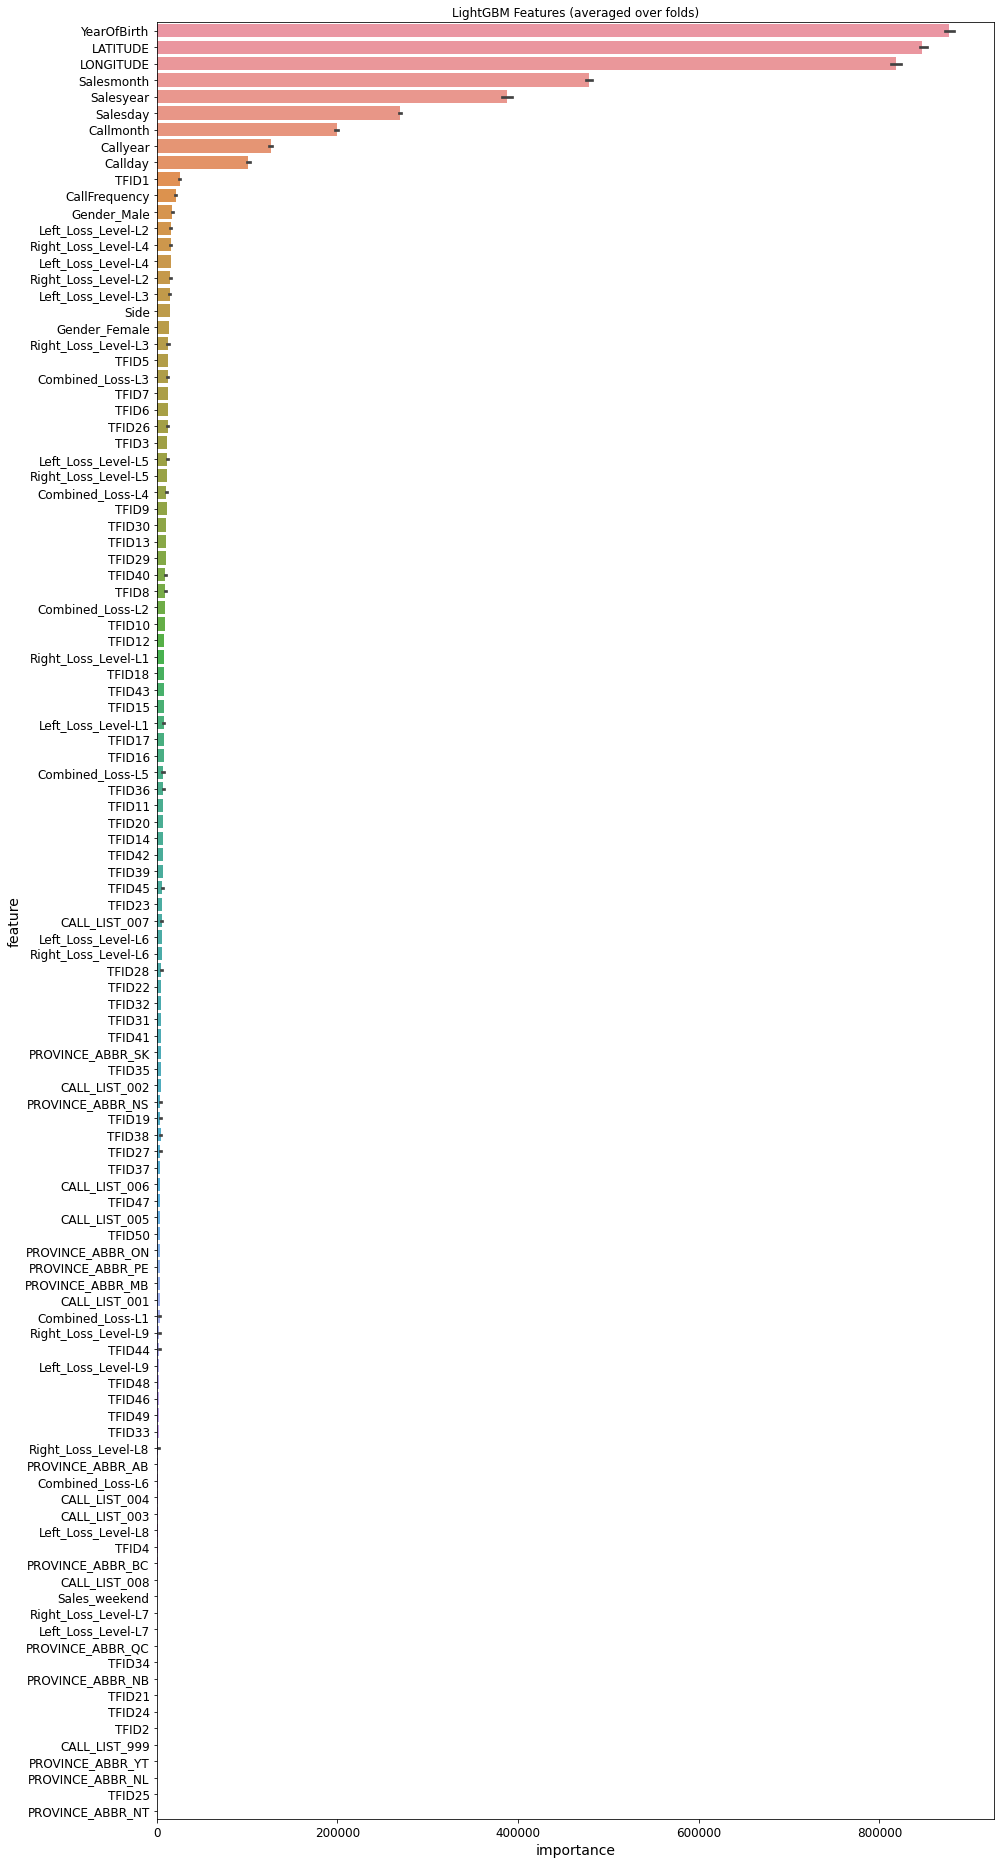

In [ ]:
import seaborn as sns
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')